In [1]:
import numpy as np
import pickle

b2h_index = [14,15,16,17,18,19,20,  # rs1~rs3, re, rw1~rw3
             37,38,39,40,41,42,43,  # ls1~ls3, le, lw1~lw3
             21,22,23,              # rh_1
             24,25,26,27,28,29,     # rh_2, rh_3
             30,31,32,33,34,35,     # rh_4, rh_5     
             44,45,46,              # lh_1
             47,48,49,50,51,52,     # lh_2, lh_3
             53,54,55,56,57,58]     # lh_4, lh_5

data_number = '15_02'
folder = "inpaint_results"
data_idx = int(data_number[:2])
print("data_idx: ", data_idx)
data_start_index = [0,3,8,16,19,26,30,37,44,54,
                    64,70,75,82,88,97,106,111,120,127,
                    136,144,151,165,171,175,181,188]
data_length = data_start_index[data_idx] - data_start_index[data_idx-1]

original_path = '../data/pkl/VAAI_DIRECT_' + data_number + '_a_M1.pkl'
with open(original_path,'rb') as f:
    data = pickle.load(f)
original_length = data['length']
original_data = data['qpos']
print("original_data.shape: ", original_data.shape)
inpainted_data = np.zeros((original_length,76))

i = data_start_index[data_idx-1]; L = 64; d_l = 0
print("start: ",i)
crh_data = np.zeros((L,76))
b2h_data = np.load("../data/%s/%.3d.png.npy" % (folder, i))
for t in range(L):
    for (b2h_data_idx, b2h_idx) in enumerate(b2h_index):
        crh_data[t,b2h_idx] = np.arctan2(b2h_data[1,t,b2h_data_idx], b2h_data[0,t,b2h_data_idx])
inpainted_data[:L,:] = crh_data
i += 1; d_l += 1

while d_l < data_length-1:
    crh_data = np.zeros((L,76))
    b2h_data = np.load("../data/%s/%.3d.png.npy" % (folder, i))
    for t in range(L):
        for (b2h_data_idx, b2h_idx) in enumerate(b2h_index):
            crh_data[t,b2h_idx] = np.arctan2(b2h_data[1,t,b2h_data_idx], b2h_data[0,t,b2h_data_idx])
    inpainted_data[32*(d_l+1):32*(d_l+2),:] = crh_data[-32:,:]
    i += 1; d_l += 1

print("end: ", i)
crh_data = np.zeros((L,76))
b2h_data = np.load("../data/%s/%.3d.png.npy" % (folder, i))
for t in range(L):
    for (b2h_data_idx, b2h_idx) in enumerate(b2h_index):
        crh_data[t,b2h_idx] = np.arctan2(b2h_data[1,t,b2h_data_idx], b2h_data[0,t,b2h_data_idx])
inpainted_data[-32:,:] = crh_data[-32:,:]

print("inpainted_data.shape: ", inpainted_data.shape)

data_idx:  15
original_data.shape:  (307, 76)
start:  88
end:  96
inpainted_data.shape:  (307, 76)


hand_data.shape:  (307, 12)


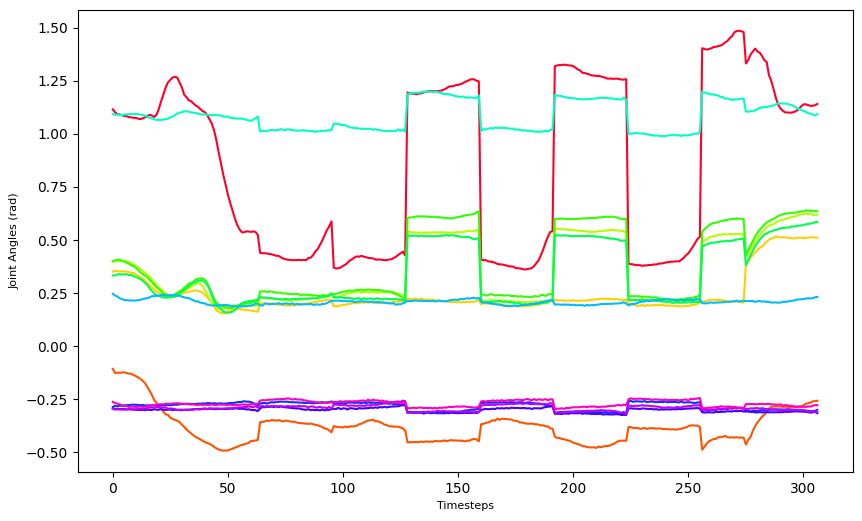

hand_data.shape:  (307, 12)


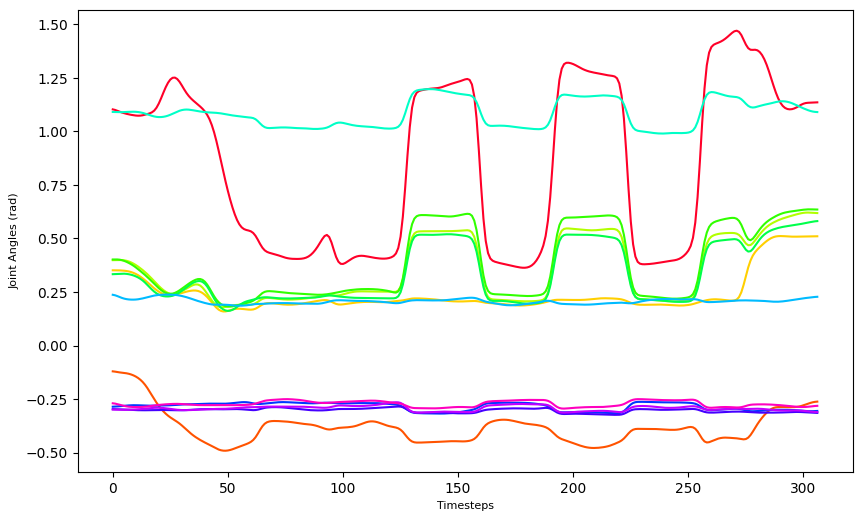

In [2]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

hand_index = [21,22,24,27,30,33,44,45,47,50,53,56]
hand_data = inpainted_data[:,hand_index]
print("hand_data.shape: ", hand_data.shape)

time = np.arange(0,original_length)
plt.figure(figsize=(10,6))
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,12)]
for i in range(12):
    plt.plot(time, hand_data[:,i], color=cs[i])

plt.xlabel('Timesteps',fontsize=8)
plt.ylabel('Joint Angles (rad)',fontsize=8)
plt.show()

smoothed_data = inpainted_data.copy()
for i in range(21,36):
    smoothed_data[:,i] = gaussian_filter1d(smoothed_data[:,i],sigma=2,axis=0)

for i in range(44,59):
    smoothed_data[:,i] = gaussian_filter1d(smoothed_data[:,i],sigma=2,axis=0)

hand_data = smoothed_data[:,hand_index]
print("hand_data.shape: ", hand_data.shape)

time = np.arange(0,original_length)
plt.figure(figsize=(10,6))
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,12)]
for i in range(12):
    plt.plot(time, hand_data[:,i], color=cs[i])

plt.xlabel('Timesteps',fontsize=8)
plt.ylabel('Joint Angles (rad)',fontsize=8)
plt.show()

inpainted_data = smoothed_data.copy()


hand_data.shape:  (307, 12)


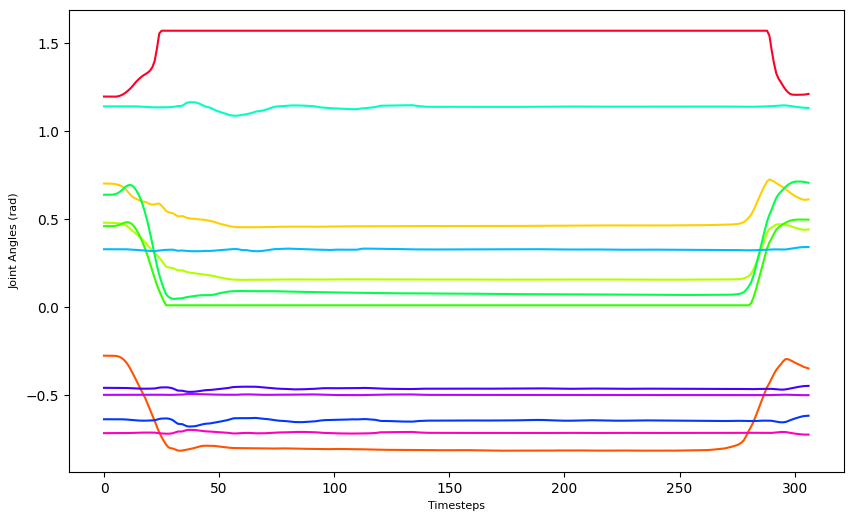

In [3]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

hand_index = [21,22,24,27,30,33,44,45,47,50,53,56]
hand_data = original_data[:,hand_index]
print("hand_data.shape: ", hand_data.shape)

time = np.arange(0,original_length)
plt.figure(figsize=(10,6))
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,12)]
for i in range(12):
    plt.plot(time, hand_data[:,i], color=cs[i])

plt.xlabel('Timesteps',fontsize=8)
plt.ylabel('Joint Angles (rad)',fontsize=8)
plt.show()


### Visualize Results + Parse `scene_common_rig_h.xml`

In [4]:
import sys
sys.path.append('../common_rig_kinematics')

import mujoco
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import rpy2r
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

xml_path = '../asset/common_rig/scene_common_rig_psyonic.xml'
env = MuJoCoParserClass(name='Common-Rig-H',rel_xml_path=xml_path,VERBOSE=True)
# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    body_idx = env.body_names.index(body_name)
    geom_idxs = [idx for idx,val in enumerate(env.model.geom_bodyid) if val==body_idx]
    for geom_idx in geom_idxs:
        env.model.geom(geom_idx).rgba = [0.3,0.3,0.5,0.5]
print ("Done.")

MuJoCo version:[2.3.7]
dt:[0.0050] HZ:[200]
n_dof (=nv):[75]
n_geom:[73]
geom_names:['floor', 'base', 'root2spine', 'spine2neck', 'neck2rclavicle', 'neck2lclavicle', 'neck2head', 'rclavicle2rshoulder', 'rshoulder2relbow', 'relbow2rwrist', 'rwrist2rmiddle', 'rmiddle2rthumb', 'rmiddle2rindex', 'rmiddle_l01', 'rmiddle2rring', 'rmiddle2rpinky', 'rthumb_l12', 'rthumb_l23', 'rthumb_l3end', 'rindex_l01', 'rindex_l12', 'rindex_l23', 'rindex_l3end', 'rmiddle_l12', 'rmiddle_l23', 'rmiddle_l3end', 'rring_l01', 'rring_l12', 'rring_l23', 'rring_l3end', 'rpinky_l01', 'rpinky_l12', 'rpinky_l23', 'rpinky_l3end', 'lclavicle2lshoulder', 'lshoulder2lelbow', 'lelbow2lwrist', 'lwrist2lthumb', 'lmiddle2lthumb', 'lmiddle2rindex', 'lmiddle_l01', 'lmiddle2rring', 'lmiddle2lpinky', 'lthumb_l12', 'lthumb_l23', 'lthumb_l3end', 'lindex_l01', 'lindex_l12', 'lindex_l23', 'lindex_l3end', 'lmiddle_l12', 'lmiddle_l23', 'lmiddle_l3end', 'lring_l01', 'lring_l12', 'lring_l23', 'lring_l3end', 'lpinky_l01', 'lpinky_l12', 'l

### Playback + Save Video

In [5]:
import cv2, os
video = []
tick = 0

SAVE_VIDEO = False
CHECK_LOOP = False
CHECK_ZOOM = False

L = data['length']

inpaint_index = [21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,
                 44,45,46,47,48,49,50,51,52,53,54,55,56,57,58]

joint_data = data['qpos'].copy()
joint_data[:,inpaint_index] = inpainted_data[:,inpaint_index]

# Initialize MuJoCo viewer
if CHECK_ZOOM:
    env.init_viewer(viewer_title='Common Rig H',viewer_width=300,viewer_height=200,
                    viewer_hide_menus=True)
else:
    env.init_viewer(viewer_title='Common Rig H',viewer_width=1200,viewer_height=800,
                    viewer_hide_menus=True)
env.update_viewer(azimuth=152,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()
tick = 0
while tick < L:
    
    q = joint_data[tick,:]
    p_root = data['root'][tick,:]
    # tick = min(tick+1,L-1)
    if CHECK_LOOP:
        if tick==(L-1): tick = 0
    tick = tick + 1

    q_couple = q.copy()

    coupled_joint_idx_list = [[22,23],[24,25,26],[27,28,29],[30,31,32],[33,34,35],
                                [45,46],[47,48,49],[50,51,52],[53,54,55],[56,57,58]]

    coupled_joint_weights_list = [[1,1],[1,3,2],[1,3,2],[1,3,2],[1,3,2],
                                    [1,1],[1,3,2],[1,3,2],[1,3,2],[1,3,2]]

    for i in range(len(coupled_joint_idx_list)):
        coupled_joint_idx = coupled_joint_idx_list[i]
        coupled_joint_weights = coupled_joint_weights_list[i]

        for j in range(len(coupled_joint_idx)):
            q_couple[coupled_joint_idx[j]] = q[coupled_joint_idx[0]] * coupled_joint_weights[j]

    env.set_p_root(root_name='base',p=p_root)
    env.forward(q=q_couple,INCREASE_TICK=True)
    if CHECK_ZOOM: env.update_viewer(azimuth=152,distance=0.45,elevation=-20,lookat=(env.get_p_body("right_wrist")+[0,0,0.03]))
    
    if env.loop_every(tick_every=1):
        # Plot world frame
        env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                   PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
        env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3,3),
                   PLOT_AXIS=False,label="tick:[%d]"%(tick))
        
        # Plot revolute joints with arrow
        # env.plot_joint_axis(axis_len=0.1,axis_r=0.01)    
        env.render()
        frame = env.grab_image()
        video.append(frame)

# Close MuJoCo viewer
env.close_viewer()

# Save Video
if SAVE_VIDEO:
    shape = video[0].shape
    video_folder = ("../video")
    if not os.path.isdir(video_folder): os.mkdir(video_folder)
    video_out = cv2.VideoWriter(os.path.join(video_folder, "%.2d_inpainted.mp4" % data_idx), cv2.VideoWriter_fourcc('M','P','4','V'), 50, (shape[1], shape[0]), True)
    if CHECK_ZOOM: video_out = cv2.VideoWriter(os.path.join(video_folder, "%.2d_inpainted_zoom.mp4" % data_idx), cv2.VideoWriter_fourcc('M','P','4','V'), 50, (shape[1], shape[0]), True)
    for i in range(len(video)):
        video_frame = cv2.cvtColor(video[i], cv2.COLOR_BGR2RGB)
        video_out.write(video_frame)
    video_out.release()

print ("Done.")

Done.


In [6]:
L = data['length']

right_wrist = []; left_wrist = []
right_thumb = []; right_index = []; right_middle = []; right_ring = []; right_pinky = []
left_thumb = []; left_index = []; left_middle = []; left_ring = []; left_pinky = []

right_abd = []; right_thumb_meta = []; right_thumb_prox = []
right_index_meta = []; right_index_prox = []; right_index_med = []
right_middle_meta = []; right_middle_prox = []; right_middle_med = []
right_ring_meta = []; right_ring_prox = []; right_ring_med = []
right_pinky_meta = []; right_pinky_prox = []; right_pinky_med = []
left_abd = []; left_thumb_meta = []; left_thumb_prox = []
left_index_meta = []; left_index_prox = []; left_index_med = []
left_middle_meta = []; left_middle_prox = []; left_middle_med = []
left_ring_meta = []; left_ring_prox = []; left_ring_med = []
left_pinky_meta = []; left_pinky_prox = []; left_pinky_med = []

# Initialize MuJoCo viewer
env.init_viewer(viewer_title='Common Rig H',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=152,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()
tick = 0
while tick < L:
    
    q = joint_data[tick,:]
    p_root = data['root'][tick,:]
    tick = tick + 1

    q_couple = q.copy()

    coupled_joint_idx_list = [[22,23],[24,25,26],[27,28,29],[30,31,32],[33,34,35],
                                [45,46],[47,48,49],[50,51,52],[53,54,55],[56,57,58]]

    coupled_joint_weights_list = [[1,1],[1,3,2],[1,3,2],[1,3,2],[1,3,2],
                                    [1,1],[1,3,2],[1,3,2],[1,3,2],[1,3,2]]

    for i in range(len(coupled_joint_idx_list)):
        coupled_joint_idx = coupled_joint_idx_list[i]
        coupled_joint_weights = coupled_joint_weights_list[i]
        joint_sum = 0

        for j in range(len(coupled_joint_idx)):
            joint_sum += q[coupled_joint_idx[j]]

        joint_sum /= np.sum(coupled_joint_weights)

        for k in range(len(coupled_joint_idx)):
            q_couple[coupled_joint_idx[k]] = joint_sum*coupled_joint_weights[k]

    env.set_p_root(root_name='base',p=p_root)
    env.forward(q=q_couple,INCREASE_TICK=True)
    
    if env.loop_every(tick_every=1):
        right_wrist.append(env.get_p_body("right_wrist"))
        left_wrist.append(env.get_p_body("left_wrist"))

        right_thumb.append(env.get_p_body("rthumb_end"))
        right_index.append(env.get_p_body("rindex_end"))
        right_middle.append(env.get_p_body("rmiddle_end"))
        right_ring.append(env.get_p_body("rring_end"))
        right_pinky.append(env.get_p_body("rpinky_end"))

        left_thumb.append(env.get_p_body("lthumb_end"))
        left_index.append(env.get_p_body("lindex_end"))
        left_middle.append(env.get_p_body("lmiddle_end"))
        left_ring.append(env.get_p_body("lring_end"))
        left_pinky.append(env.get_p_body("lpinky_end"))

        right_abd.append(q_couple[21]); right_thumb_meta.append(q_couple[22]); right_thumb_prox.append(q_couple[23])
        right_index_meta.append(q_couple[24]); right_index_prox.append(q_couple[25]); right_index_med.append(q_couple[26])
        right_middle_meta.append(q_couple[27]); right_middle_prox.append(q_couple[28]); right_middle_med.append(q_couple[29])
        right_ring_meta.append(q_couple[30]); right_ring_prox.append(q_couple[31]); right_ring_med.append(q_couple[32])
        right_pinky_meta.append(q_couple[33]); right_pinky_prox.append(q_couple[34]); right_pinky_med.append(q_couple[35])
        left_abd.append(q_couple[44]); left_thumb_meta.append(q_couple[45]); left_thumb_prox.append(q_couple[46])
        left_index_meta.append(q_couple[47]); left_index_prox.append(q_couple[48]); left_index_med.append(q_couple[49])
        left_middle_meta.append(q_couple[50]); left_middle_prox.append(q_couple[51]); left_middle_med.append(q_couple[52])
        left_ring_meta.append(q_couple[53]); left_ring_prox.append(q_couple[54]); left_ring_med.append(q_couple[55])
        left_pinky_meta.append(q_couple[56]); left_pinky_prox.append(q_couple[57]); left_pinky_med.append(q_couple[58])

# Close MuJoCo viewer
env.close_viewer()

print ("Done.")

Done.


In [8]:
import pickle

with open('../data/metric/pos' + data_number[:2] + '.pkl','rb') as f:
    pos = pickle.load(f)

with open('../data/metric/angle' + data_number[:2] + '.pkl','rb') as f:
    angle = pickle.load(f)

l2_dist = 0

for joint_pos in (['right_thumb', 'right_index', 'right_middle', 'right_ring', 'right_pinky',
                  'left_thumb', 'left_index', 'left_middle', 'left_ring', 'left_pinky']):
    a = pos[joint_pos]
    b = np.array(eval(joint_pos))
    diff = a-b
    dist = np.sqrt(diff[:,0]**2 + diff[:,0]**2 + diff[:,2]**2)
    l2_dist += np.average(dist)

print("L2 Distance (mm): ",l2_dist*1000/10)

mpjre = 0

for joint_angle in (['right_abd', 'right_thumb_meta', 'right_thumb_prox',
                     'right_index_meta', 'right_index_prox', 'right_index_med',
                     'right_middle_meta', 'right_middle_prox', 'right_middle_med',
                     'right_ring_meta', 'right_ring_prox', 'right_ring_med',
                     'right_pinky_meta', 'right_pinky_prox', 'right_pinky_med',
                     'left_abd', 'left_thumb_meta', 'left_thumb_prox',
                     'left_index_meta', 'left_index_prox', 'left_index_med',
                     'left_middle_meta', 'left_middle_prox', 'left_middle_med',
                     'left_ring_meta', 'left_ring_prox', 'left_ring_med',
                     'left_pinky_meta', 'left_pinky_prox', 'left_pinky_med']):
    c = angle[joint_angle]
    d = np.array(eval(joint_angle))
    mpjre += np.average(np.abs(c-d))

print("MPJRE: ", np.degrees(mpjre/30))

L2 Distance (mm):  26.362699123603228
MPJRE:  12.38261964070709


In [10]:
data_numbers = ["01_01","02_01","03_01","04_01","05_01","06_02","07_01","08_01","09_02","10_01",
                "11_01","12_02","13_01","14_01","15_02","16_02","17_01","18_01","19_01","20_01",
                "21_01","22_01","23_01","24_01","25_02","26_01","27_01"]

l2_list = []; mpjre_list = []

for data_number in data_numbers:
    folder = "inpaint_results"
    data_idx = int(data_number[:2])
    data_start_index = [0,3,8,16,19,26,30,37,44,54,
                        64,70,75,82,88,97,106,111,120,127,
                        136,144,151,165,171,175,181,188]
    data_length = data_start_index[data_idx] - data_start_index[data_idx-1]

    original_path = '../data/pkl/VAAI_DIRECT_' + data_number + '_a_M1.pkl'
    with open(original_path,'rb') as f:
        data = pickle.load(f)
    original_length = data['length']
    original_data = data['qpos']
    inpainted_data = np.zeros((original_length,76))

    i = data_start_index[data_idx-1]; L = 64; d_l = 0
    crh_data = np.zeros((L,76))
    b2h_data = np.load("../data/%s/%.3d.png.npy" % (folder, i))
    for t in range(L):
        for (b2h_data_idx, b2h_idx) in enumerate(b2h_index):
            crh_data[t,b2h_idx] = np.arctan2(b2h_data[1,t,b2h_data_idx], b2h_data[0,t,b2h_data_idx])
    inpainted_data[:L,:] = crh_data
    i += 1; d_l += 1

    while d_l < data_length-1:
        crh_data = np.zeros((L,76))
        b2h_data = np.load("../data/%s/%.3d.png.npy" % (folder, i))
        for t in range(L):
            for (b2h_data_idx, b2h_idx) in enumerate(b2h_index):
                crh_data[t,b2h_idx] = np.arctan2(b2h_data[1,t,b2h_data_idx], b2h_data[0,t,b2h_data_idx])
        inpainted_data[32*(d_l+1):32*(d_l+2),:] = crh_data[-32:,:]
        i += 1; d_l += 1

    crh_data = np.zeros((L,76))
    b2h_data = np.load("../data/%s/%.3d.png.npy" % (folder, i))
    for t in range(L):
        for (b2h_data_idx, b2h_idx) in enumerate(b2h_index):
            crh_data[t,b2h_idx] = np.arctan2(b2h_data[1,t,b2h_data_idx], b2h_data[0,t,b2h_data_idx])
    inpainted_data[-32:,:] = crh_data[-32:,:]

    smoothed_data = inpainted_data.copy()
    for i in range(21,36):
        smoothed_data[:,i] = gaussian_filter1d(smoothed_data[:,i],sigma=5,axis=0)

    for i in range(44,59):
        smoothed_data[:,i] = gaussian_filter1d(smoothed_data[:,i],sigma=5,axis=0)

    inpainted_data = smoothed_data.copy()

    L = data['length']

    inpaint_index = [21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,
                 44,45,46,47,48,49,50,51,52,53,54,55,56,57,58]

    joint_data = data['qpos'].copy()
    joint_data[:,inpaint_index] = inpainted_data[:,inpaint_index]


    right_wrist = []; left_wrist = []
    right_thumb = []; right_index = []; right_middle = []; right_ring = []; right_pinky = []
    left_thumb = []; left_index = []; left_middle = []; left_ring = []; left_pinky = []

    right_abd = []; right_thumb_meta = []; right_thumb_prox = []
    right_index_meta = []; right_index_prox = []; right_index_med = []
    right_middle_meta = []; right_middle_prox = []; right_middle_med = []
    right_ring_meta = []; right_ring_prox = []; right_ring_med = []
    right_pinky_meta = []; right_pinky_prox = []; right_pinky_med = []
    left_abd = []; left_thumb_meta = []; left_thumb_prox = []
    left_index_meta = []; left_index_prox = []; left_index_med = []
    left_middle_meta = []; left_middle_prox = []; left_middle_med = []
    left_ring_meta = []; left_ring_prox = []; left_ring_med = []
    left_pinky_meta = []; left_pinky_prox = []; left_pinky_med = []

    # Initialize MuJoCo viewer
    env.init_viewer(viewer_title='Common Rig H',viewer_width=1200,viewer_height=800,
                    viewer_hide_menus=True)
    env.update_viewer(azimuth=152,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
    env.reset()
    tick = 0
    while tick < L:
        
        q = joint_data[tick,:]
        p_root = data['root'][tick,:]
        tick = tick + 1

        q_couple = q.copy()

        coupled_joint_idx_list = [[22,23],[24,25,26],[27,28,29],[30,31,32],[33,34,35],
                                [45,46],[47,48,49],[50,51,52],[53,54,55],[56,57,58]]

        coupled_joint_weights_list = [[1,1],[1,3,2],[1,3,2],[1,3,2],[1,3,2],
                                        [1,1],[1,3,2],[1,3,2],[1,3,2],[1,3,2]]

        for i in range(len(coupled_joint_idx_list)):
            coupled_joint_idx = coupled_joint_idx_list[i]
            coupled_joint_weights = coupled_joint_weights_list[i]
            joint_sum = 0

            for j in range(len(coupled_joint_idx)):
                joint_sum += q[coupled_joint_idx[j]]

            joint_sum /= np.sum(coupled_joint_weights)

            for k in range(len(coupled_joint_idx)):
                q_couple[coupled_joint_idx[k]] = joint_sum*coupled_joint_weights[k]

        env.set_p_root(root_name='base',p=p_root)
        env.forward(q=q_couple,INCREASE_TICK=True)
        
        if env.loop_every(tick_every=1):
            right_wrist.append(env.get_p_body("right_wrist"))
            left_wrist.append(env.get_p_body("left_wrist"))

            right_thumb.append(env.get_p_body("rthumb_end"))
            right_index.append(env.get_p_body("rindex_end"))
            right_middle.append(env.get_p_body("rmiddle_end"))
            right_ring.append(env.get_p_body("rring_end"))
            right_pinky.append(env.get_p_body("rpinky_end"))

            left_thumb.append(env.get_p_body("lthumb_end"))
            left_index.append(env.get_p_body("lindex_end"))
            left_middle.append(env.get_p_body("lmiddle_end"))
            left_ring.append(env.get_p_body("lring_end"))
            left_pinky.append(env.get_p_body("lpinky_end"))

            right_abd.append(q_couple[21]); right_thumb_meta.append(q_couple[22]); right_thumb_prox.append(q_couple[23])
            right_index_meta.append(q_couple[24]); right_index_prox.append(q_couple[25]); right_index_med.append(q_couple[26])
            right_middle_meta.append(q_couple[27]); right_middle_prox.append(q_couple[28]); right_middle_med.append(q_couple[29])
            right_ring_meta.append(q_couple[30]); right_ring_prox.append(q_couple[31]); right_ring_med.append(q_couple[32])
            right_pinky_meta.append(q_couple[33]); right_pinky_prox.append(q_couple[34]); right_pinky_med.append(q_couple[35])
            left_abd.append(q_couple[44]); left_thumb_meta.append(q_couple[45]); left_thumb_prox.append(q_couple[46])
            left_index_meta.append(q_couple[47]); left_index_prox.append(q_couple[48]); left_index_med.append(q_couple[49])
            left_middle_meta.append(q_couple[50]); left_middle_prox.append(q_couple[51]); left_middle_med.append(q_couple[52])
            left_ring_meta.append(q_couple[53]); left_ring_prox.append(q_couple[54]); left_ring_med.append(q_couple[55])
            left_pinky_meta.append(q_couple[56]); left_pinky_prox.append(q_couple[57]); left_pinky_med.append(q_couple[58])

    # Close MuJoCo viewer
    env.close_viewer()

    with open('../data/metric/pos' + data_number[:2] + '.pkl','rb') as f:
        pos = pickle.load(f)

    with open('../data/metric/angle' + data_number[:2] + '.pkl','rb') as f:
        angle = pickle.load(f)

    l2_dist = 0

    for joint_pos in (['right_thumb', 'right_index', 'right_middle', 'right_ring', 'right_pinky',
                      'left_thumb', 'left_index', 'left_middle', 'left_ring', 'left_pinky']):
                        # ]):
        a = pos[joint_pos]
        b = np.array(eval(joint_pos))
        diff = a-b
        dist = np.sqrt(diff[:,0]**2 + diff[:,1]**2 + diff[:,2]**2)
        l2_dist += np.average(dist)

    l2_list.append(l2_dist*1000/10)
    print("%d L2 Distance (mm): %.4f" % (data_idx, l2_dist*1000/10))

    mpjre = 0

    for joint_angle in (['right_abd', 'right_thumb_meta', 'right_thumb_prox',
                        'right_index_meta', 'right_index_prox', 'right_index_med',
                        'right_middle_meta', 'right_middle_prox', 'right_middle_med',
                        'right_ring_meta', 'right_ring_prox', 'right_ring_med',
                        'right_pinky_meta', 'right_pinky_prox', 'right_pinky_med',
                        'left_abd', 'left_thumb_meta', 'left_thumb_prox',
                        'left_index_meta', 'left_index_prox', 'left_index_med',
                        'left_middle_meta', 'left_middle_prox', 'left_middle_med',
                        'left_ring_meta', 'left_ring_prox', 'left_ring_med',
                        'left_pinky_meta', 'left_pinky_prox', 'left_pinky_med']):
        c = angle[joint_angle]
        d = np.array(eval(joint_angle))
        mpjre += np.average(np.abs(c-d))

    mpjre_list.append(np.degrees(mpjre)/30)
    print("%d MPJRE (deg): %.2f" % (data_idx, np.degrees(mpjre)/30))

1 L2 Distance (mm): 5.7795
1 MPJRE (deg): 2.39
2 L2 Distance (mm): 20.3516
2 MPJRE (deg): 8.75
3 L2 Distance (mm): 8.8868
3 MPJRE (deg): 3.61
4 L2 Distance (mm): 4.2006
4 MPJRE (deg): 1.68
5 L2 Distance (mm): 15.2361
5 MPJRE (deg): 6.03
6 L2 Distance (mm): 16.9805
6 MPJRE (deg): 6.84
7 L2 Distance (mm): 3.1664
7 MPJRE (deg): 1.26
8 L2 Distance (mm): 8.4988
8 MPJRE (deg): 3.44
9 L2 Distance (mm): 18.2141
9 MPJRE (deg): 8.16
10 L2 Distance (mm): 14.4471
10 MPJRE (deg): 5.80
11 L2 Distance (mm): 20.1621
11 MPJRE (deg): 8.63
12 L2 Distance (mm): 15.8952
12 MPJRE (deg): 6.27
13 L2 Distance (mm): 3.5287
13 MPJRE (deg): 1.40
14 L2 Distance (mm): 9.5518
14 MPJRE (deg): 3.99
15 L2 Distance (mm): 27.9480
15 MPJRE (deg): 12.30
16 L2 Distance (mm): 35.6252
16 MPJRE (deg): 15.15
17 L2 Distance (mm): 31.8198
17 MPJRE (deg): 15.64
18 L2 Distance (mm): 7.7956
18 MPJRE (deg): 3.14
19 L2 Distance (mm): 20.5683
19 MPJRE (deg): 8.57
20 L2 Distance (mm): 21.1688
20 MPJRE (deg): 9.22
21 L2 Distance (mm): 14

In [11]:
l2_list = np.array(l2_list)
print("L2 Distance (mm): %.2f +/- %.2f" % (np.mean(l2_list), np.std(l2_list)))
mpjre_list = np.array(mpjre_list)
print("MPJRE (deg): %.2f +/- %.2f" % (np.mean(mpjre_list), np.std(mpjre_list)))

L2 Distance (mm): 16.15 +/- 8.91
MPJRE (deg): 6.90 +/- 4.19
